In [1]:
### PYCHARM ###

import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *


from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch


path = "dataset_CIFAR10"


In [3]:
### COLAB ###
"""
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.callback.fp16 import *

!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip
path = "/content/"
"""

'\n! [ -e /content ] && pip install -Uqq fastbook\nimport fastbook\nfrom fastbook import *\nfastbook.setup_book()\nfrom fastai.callback.fp16 import *\n\n!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip\npath = "/content/"\n'

In [4]:
#check if cuda is available
torch.cuda.is_available()

True

In [2]:
dls = ImageDataLoaders.from_folder(
    path=path,
    train='train',
    valid='validation',
    seed=42,
    bs = 64,
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

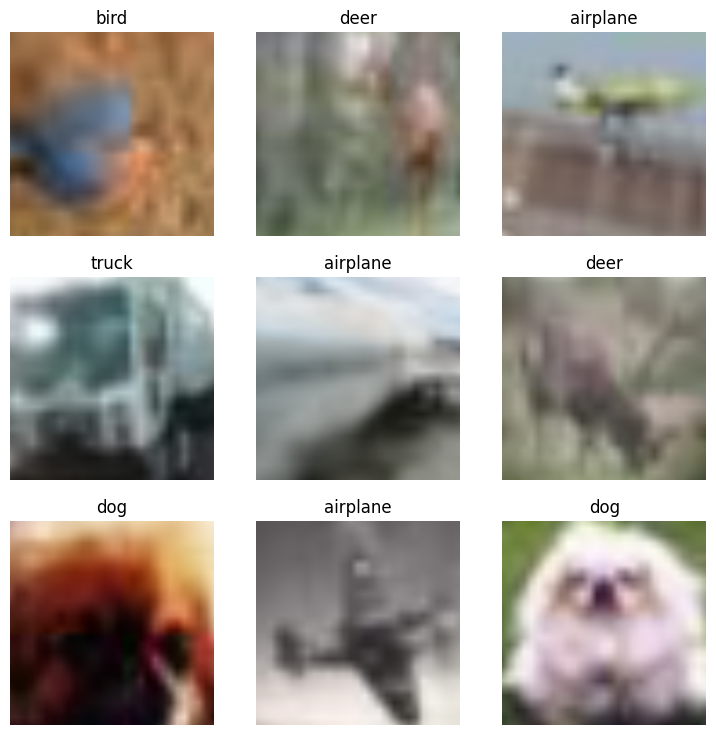

In [5]:
dls.show_batch()

En aquest apartat compararem el resultat de diferents xarxes resnets (18, 50, 152) sense aplicar cap transformació a les imatges, per aconseguir la puntuació baseline.  

#### RESNET18

In [6]:
learn18 = vision_learner(dls, resnet18, metrics=[accuracy, error_rate]).to_fp16()
learn18.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.909935,0.732003,0.743700,0.256300,01:17
1,0.711354,0.567475,0.804600,0.195400,01:17
2,0.565601,0.485929,0.833800,0.166200,01:17
3,0.469026,0.431033,0.851000,0.149000,01:16
4,0.407999,0.419046,0.855700,0.144300,01:17
5,0.378207,0.420565,0.854200,0.145800,01:17


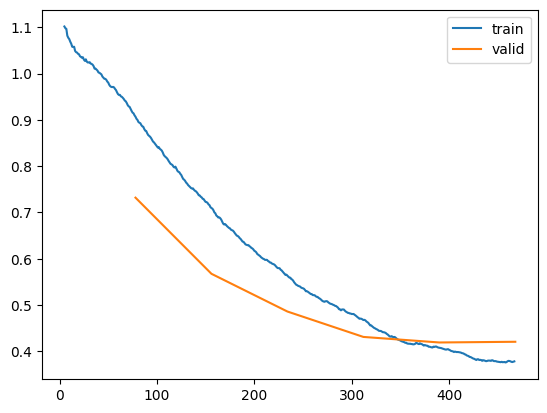

In [7]:
#plot loss and accuracy
learn18.recorder.plot_loss()

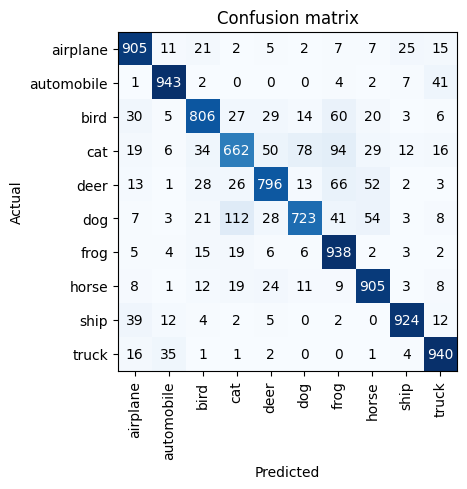

In [8]:
#plot confusion matrix
interp18 = ClassificationInterpretation.from_learner(learn18)
interp18.plot_confusion_matrix()

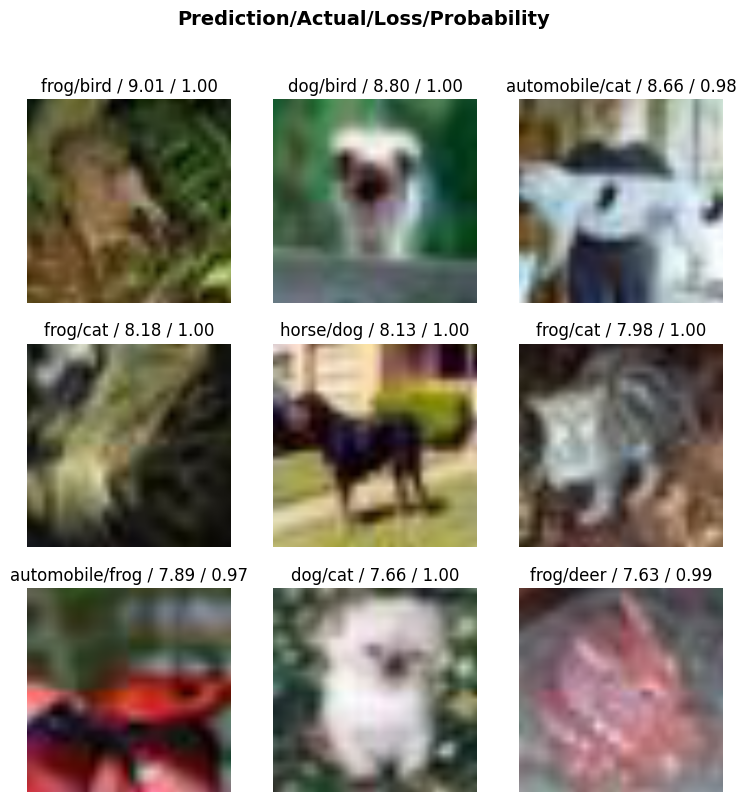

In [9]:
#plot top losses
interp18.plot_top_losses(9, nrows=3)

#### RESNET50

In [6]:
learn50 = vision_learner(dls, resnet50, metrics=[accuracy, error_rate]).to_fp16()
learn50.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.515143,0.432645,0.850500,0.149500,02:55
1,0.440167,0.371903,0.874700,0.125300,02:38
2,0.339372,0.345518,0.885000,0.115000,02:34
3,0.230525,0.269642,0.908800,0.091200,02:34
4,0.151895,0.252150,0.919700,0.080300,02:34
5,0.121216,0.244585,0.921900,0.078100,02:34


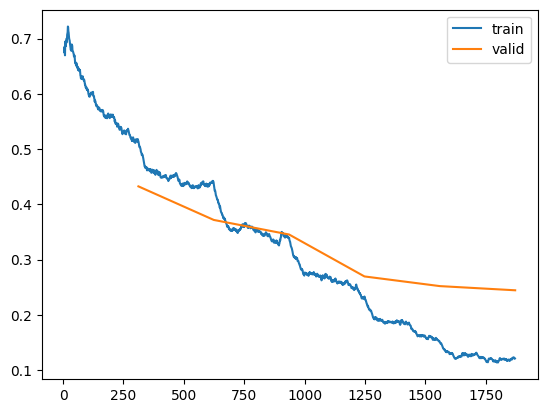

In [7]:
learn50.recorder.plot_loss()

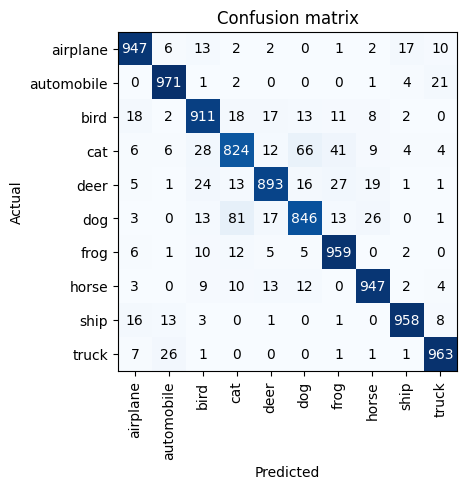

In [8]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_confusion_matrix()

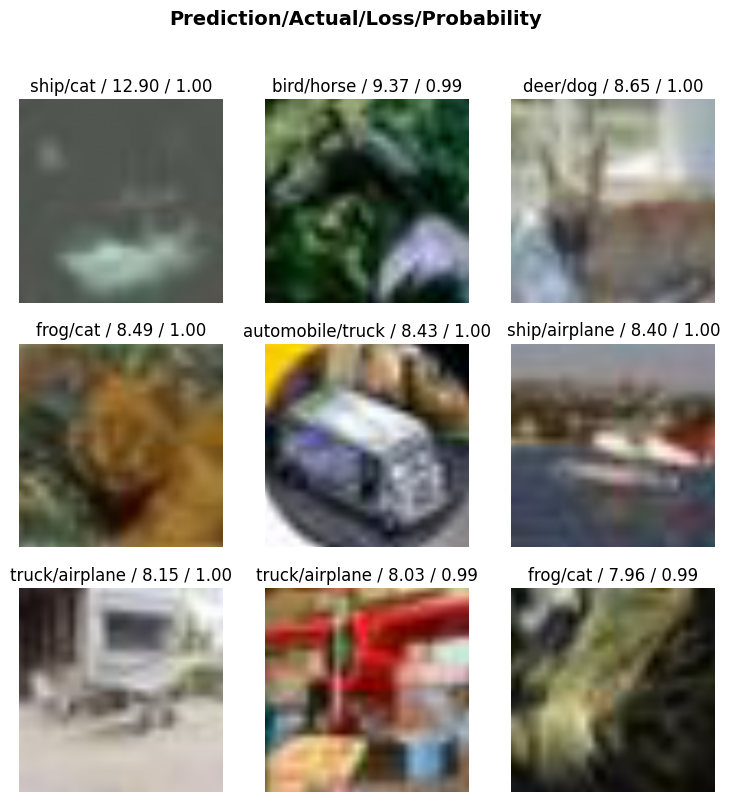

In [9]:
interp50.plot_top_losses(9, nrows=3)

#### RESNET152

In [3]:
learn152 = vision_learner(dls, resnet152, metrics=[accuracy, error_rate]).to_fp16()
learn152.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.411964,0.346882,0.881300,0.118700,05:29
1,0.446776,0.421264,0.857100,0.142900,05:16
2,0.333096,0.337319,0.892600,0.107400,05:15
3,0.219208,0.245287,0.919500,0.080500,04:59
4,0.129526,0.195251,0.934200,0.065800,04:51
5,0.082424,0.179853,0.941700,0.058300,04:51


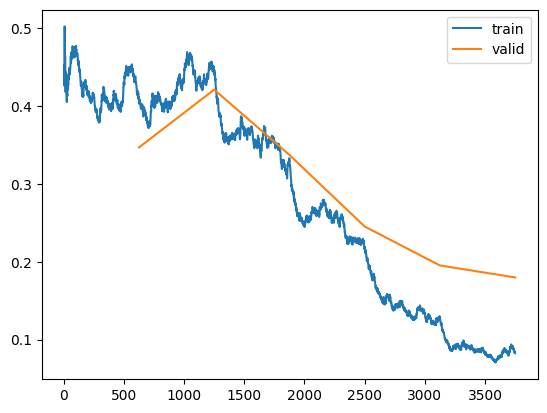

In [4]:
learn152.recorder.plot_loss()

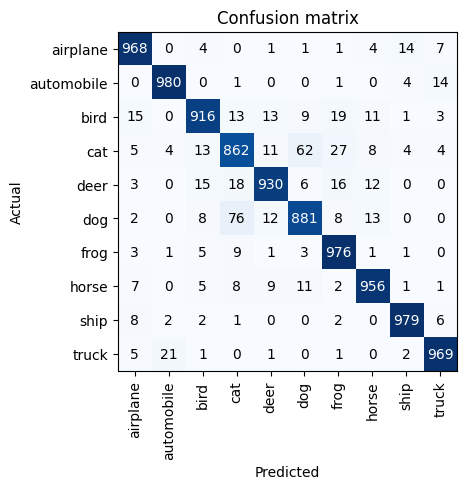

In [5]:
inter152 = ClassificationInterpretation.from_learner(learn152)
inter152.plot_confusion_matrix()

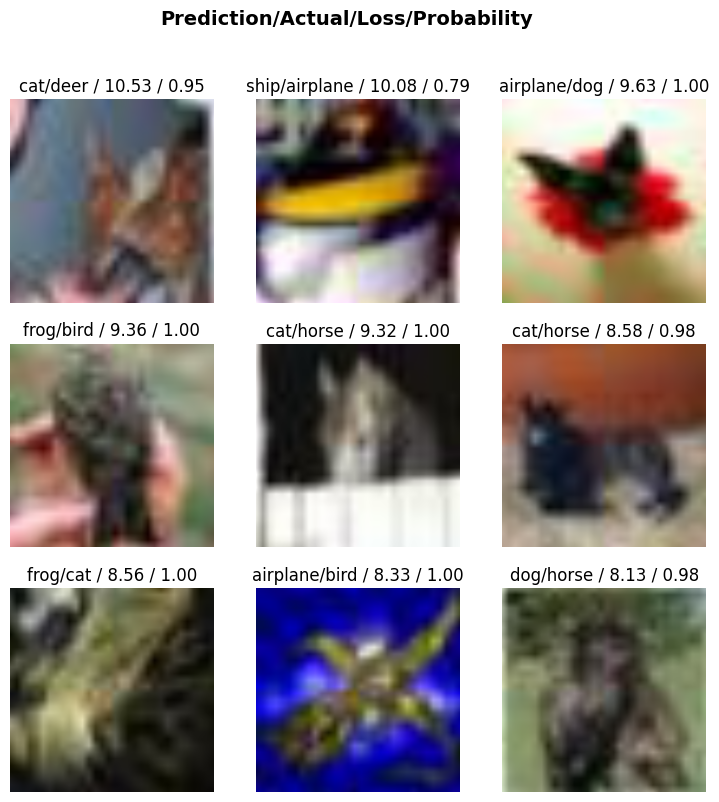

In [6]:
inter152.plot_top_losses(9, nrows=3)

#### Anàlisi de resultats

Fixant que les imatges siguin de mida 224x224 (resolució amb la qual s'han entrenat els models resnet), aplicant les transformacions que aplica per defecte FASTAI amb la funció aug_transforms,  amb 3 èpoques de congelació i 6 d'entrenament, veiem com els resultats milloren considerablement, ja que tenim:
- RESNET 18: 85% d'accuracy
- RESNET 50: 92% d'accuracy
- RESNET 152: 94% d'accuracy


#### Data augmentation sobre resnet152

Per tal de millorar els resultats, provarem d'aplicar Mixup i CutMix sobre el model resnet152. El primer consisteix en combinar dues imatges (aplicant una combinació lineal entre les dues), mentre que en el segon cas, es retalla una imatge de forma aleatòria i aquest retall es posa sobre d'una altra. A part de diferents transformacions, aplicarem la funció de pèrdua CrossEntropyLossFlat(),

In [7]:
dls = ImageDataLoaders.from_folder(
    path=path,
    train='train',
    valid='validation',
    seed=42,
    bs = 32,
    batch_tfms=aug_transforms(size=224, min_scale=0.75, flip_vert=True, max_rotate=10.0, max_lighting=0.2, max_zoom=1.1, max_warp=0.2),
)

# Load the pre-trained ResNet152 model
learn152 = vision_learner(dls, resnet152, metrics=[accuracy, error_rate], loss_func=CrossEntropyLossFlat())

##### MixUp

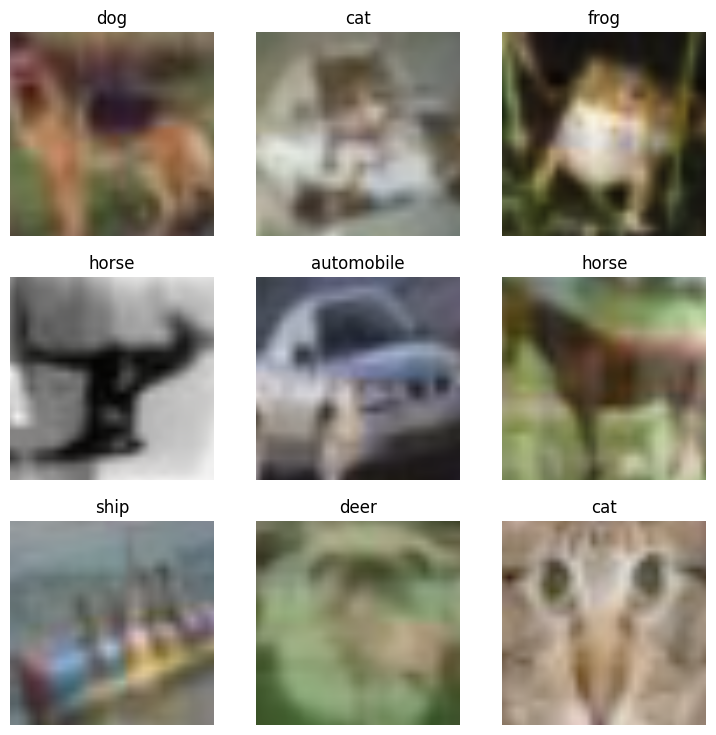

In [3]:
mixup = MixUp(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

In [2]:
learn152.fine_tune(6, freeze_epochs=3, cbs=MixUp(1.))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.479513,0.643840,0.794000,0.206000,09:24
1,1.510309,0.646645,0.797200,0.202800,09:26
2,1.424330,0.537484,0.835600,0.164400,09:27
3,1.346588,0.443451,0.866100,0.133900,09:31
4,1.299491,0.379742,0.891200,0.108800,09:51
5,1.256649,0.349796,0.900100,0.099900,09:55


##### CutMix

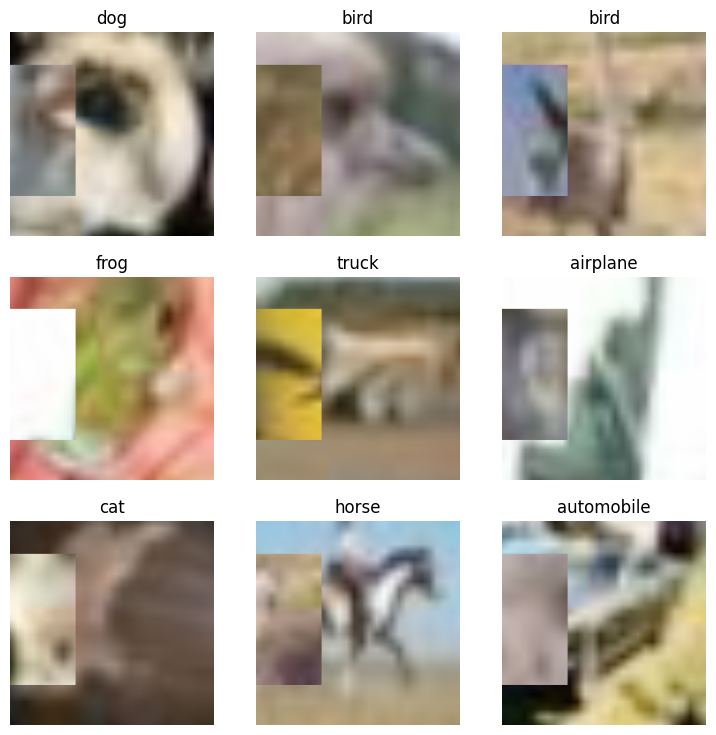

In [4]:
cutmix = CutMix(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

In [8]:
learn152.fine_tune(6, freeze_epochs=3, cbs=CutMix(1.))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.517517,0.608518,0.809900,0.190100,09:23
1,1.508420,0.620130,0.810500,0.189500,09:34
2,1.382758,0.514095,0.840300,0.159700,09:11
3,1.273616,0.409620,0.873600,0.126400,09:16
4,1.187738,0.320517,0.905500,0.094500,10:03
5,1.174919,0.309916,0.904900,0.095100,09:11


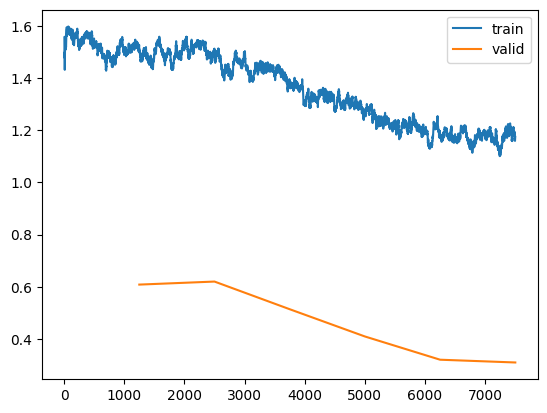

In [9]:
learn152.recorder.plot_loss()

#### Conclusions

Veiem com en els dos casos de data augmentation estem fent overfitting, i els requisits de memòria han augmentat, per això el temps per epoch augmenta considerablement. Per tant, de moment, el millor model de moment continua sent una xarxa resnet152 amb les transformacions per defecte.